# Schedule-Adjusted League Table

League tables earlier in the season heavily depend on team schedules. Since all teams did not face each other, the league table represents poorly relative team strengths.

The original idea is from a [StastBomb Blog Post](https://statsbomb.com/2018/11/introducing-the-schedule-adjusted-league-table/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('default')

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
from highlight_text import fig_text

body_font = "Open Sans"
watermark_font = "DejaVu Sans"
text_color = "w"
background = "#282B2F"
title_font = "DejaVu Sans"

mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['text.color'] = text_color
mpl.rcParams['axes.edgecolor'] = text_color
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6

In [3]:
colors = {
    # https://teamcolorcodes.com/soccer/premier-league-color-codes/
    'ARS': '#EF0107',
    'AVL': '#95bfe5',
    'BHA': '#0057B8',
    'BRE': '#DA291C',
    'BUR': '#6C1D45',
    'CHE': '#034694',
    'CRY': '#1B458F',
    'EVE': '#003399',
    'LEI': '#003090',
    'LEE': '#FFCD00',
    'LIV': '#c8102E',
    'MCI': '#6CABDD',
    'MUN': '#DA291C',
    'NOR': '#FFF200',
    'NEW': '#241F20',
    'SOU': '#d71920',
    'TOT': '#132257',
    'WAT': '#FBEE23',
    'WHU': '#7A263A',
    'WOL': '#FDB913'
}

In [4]:
logos = {
    # https://www.transfermarkt.com/premier-league/transfers/wettbewerb/GB1
    'Arsenal': '../data/logos/ARS.png',
    'Aston Villa': '../data/logos/AVL.png',
    'Brighton and Hove Albion': '../data/logos/BHA.png',
    'Brentford': '../data/logos/BRE.png',
    'Burnley': '../data/logos/BUR.png',
    'Chelsea': '../data/logos/CHE.png',
    'Crystal Palace': '../data/logos/CRY.png',
    'Everton': '../data/logos/EVE.png',
    'Leicester City': '../data/logos/LEI.png',
    'Leeds United': '../data/logos/LEE.png',
    'Liverpool': '../data/logos/LIV.png',
    'Manchester City': '../data/logos/MCI.png',
    'Manchester United': '../data/logos/MUN.png',
    'Norwich City': '../data/logos/NOR.png',
    'Newcastle': '../data/logos/NEW.png',
    'Southampton': '../data/logos/SOU.png',
    'Tottenham Hotspur': '../data/logos/TOT.png',
    'Watford': '../data/logos/WAT.png',
    'West Ham United': '../data/logos/WHU.png',
    'Wolverhampton': '../data/logos/WOL.png',
}

In [5]:
fixtures = pd.read_csv(
    '../data/fpl_official/vaastav/data/2021-22/fixtures.csv')

league_table = pd.read_csv(
    '../data/fpl_official/vaastav/data/2021-22/teams.csv'
    )[['id', 'name', 'short_name']]

In [6]:
league_table = league_table.replace({
    'Brighton': 'Brighton and Hove Albion',
    'Leicester': 'Leicester City',
    'Leeds': 'Leeds United',
    'Man City': 'Manchester City',
    'Man Utd': 'Manchester United',
    'Norwich': 'Norwich City',
    'Spurs': 'Tottenham Hotspur',
    'West Ham': 'West Ham United',
    'Wolves': 'Wolverhampton'
})

## Actual League Table

In [7]:
from SALT import SALT

salt = SALT(fixtures, league_table)
salt.lt()
salt.league_table.sort_values(by=['points'], ascending=False)

,id,name,short_name,points
11,12,Manchester City,MCI,93
10,11,Liverpool,LIV,92
5,6,Chelsea,CHE,74
16,17,Tottenham Hotspur,TOT,71
0,1,Arsenal,ARS,69
12,13,Manchester United,MUN,58
18,19,West Ham United,WHU,56
8,9,Leicester City,LEI,52
3,4,Brighton and Hove Albion,BHA,51
19,20,Wolverhampton,WOL,51


## SALT

In [8]:
salt.salt()

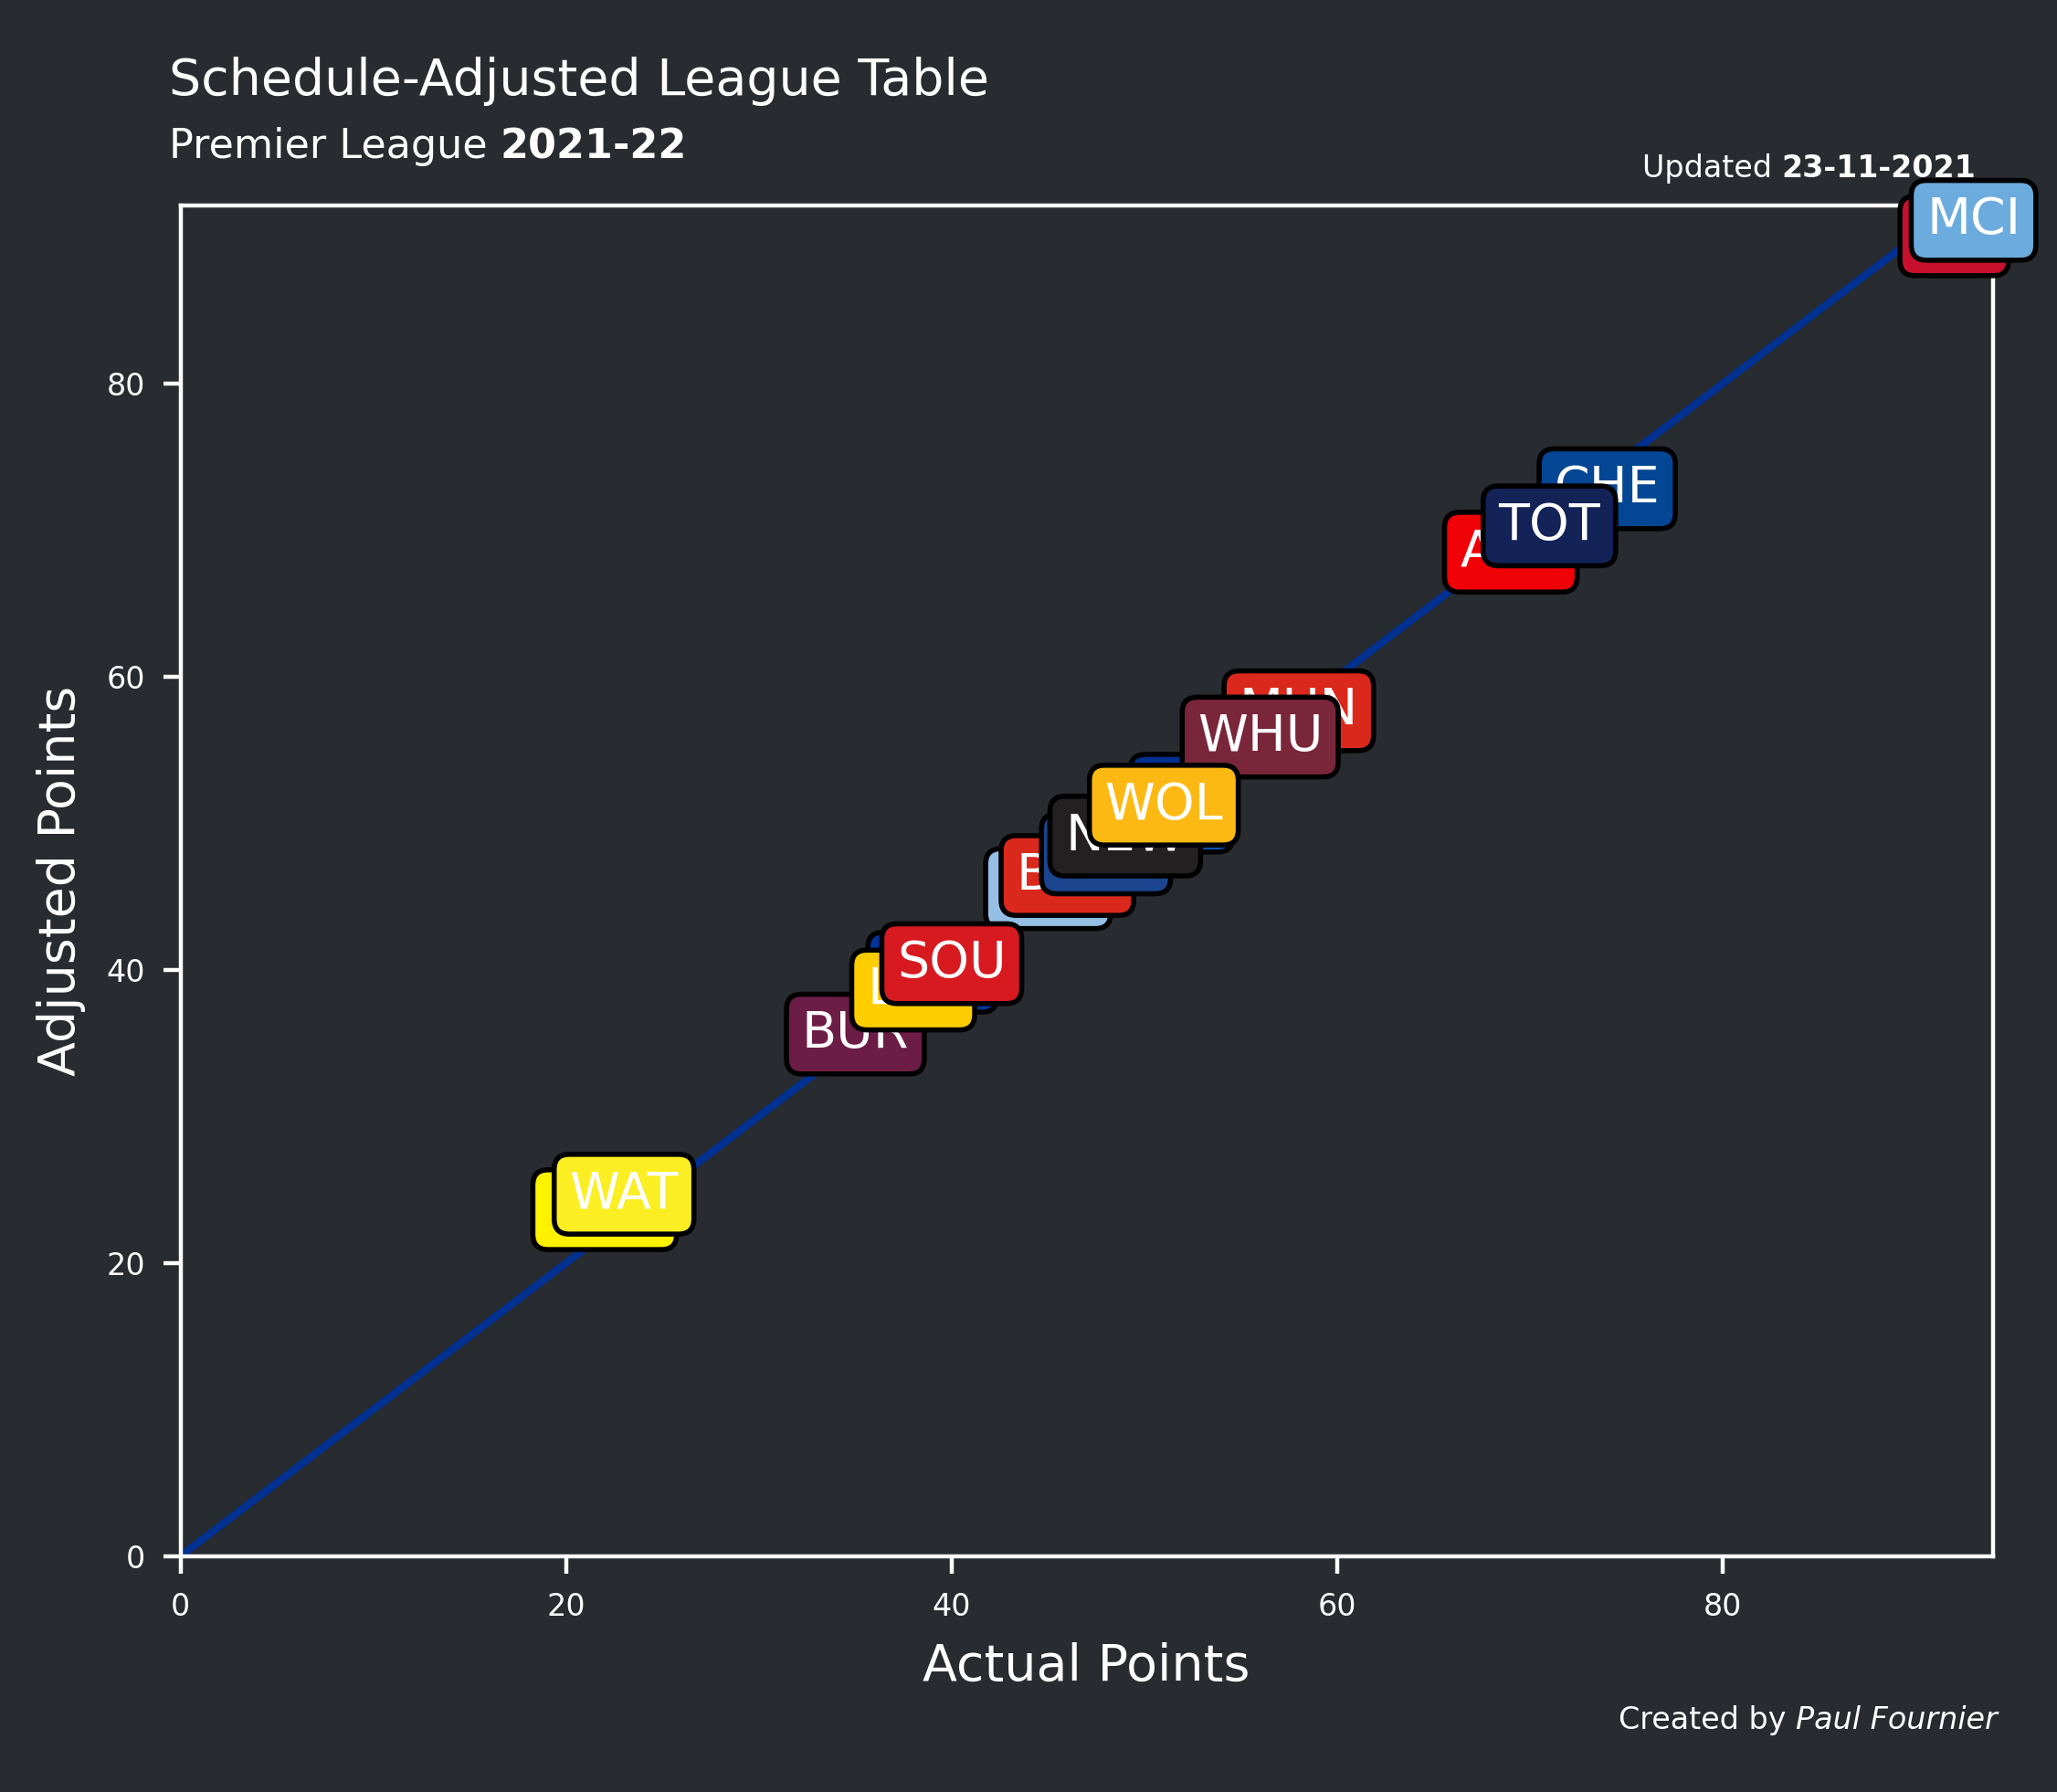

In [9]:
fig, ax = plt.subplots()
fig.set_facecolor(background)
ax.patch.set_alpha(0)

max_1 = salt.league_table["adj_points"].max()
max_2 = salt.league_table["points"].max()
ax.set(xlim=(0, max_2+1), ylim=(0, max_1+1))

ax.set_xlabel('Actual Points')
ax.set_ylabel('Adjusted Points')
ax.xaxis.label.set_color(text_color)
ax.yaxis.label.set_color(text_color)

ref_line = [0.0, max(max_1, max_2)+1]
ax.plot(ref_line, ref_line, color='#003090')

for idx, row in salt.league_table.iterrows():
    ax.annotate(row.values[2],
                xy=(row["points"], row["adj_points"]),
                xycoords='data',
                bbox=dict(boxstyle='round', fc=(colors[row.values[2]])),
                ha='center',
                va='center',
                color='white')

fig_text(
    x=0.12, y=0.965,
    s="Schedule-Adjusted League Table",
    fontsize=10, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.12, y=0.925,
    s="Premier League <2021-22>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=8, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.75, y=0.91,
    s="Updated <23-11-2021>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=6, fontfamily=title_font, color=text_color, alpha=1)

fig_text(
    x=0.74, y=0.025,
    s="Created by <Paul Fournier>",
    highlight_textprops=[{"fontstyle": "italic"}],
    fontsize=6, fontfamily=watermark_font,
    color=text_color)

plt.show()

In [10]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def get_logo(name):
    return plt.imread(logos[name])

def offset_image(xcoord, ycoord, name, ax):
    img = get_logo(name)
    im = OffsetImage(img, zoom=0.20)
    im.image.axes = ax

    ab = AnnotationBbox(
        im,
        ((xcoord+1.3)/max_pts, (ycoord+1.3)/max_adj),
        frameon=False, xycoords='axes fraction')

    ax.add_artist(ab)

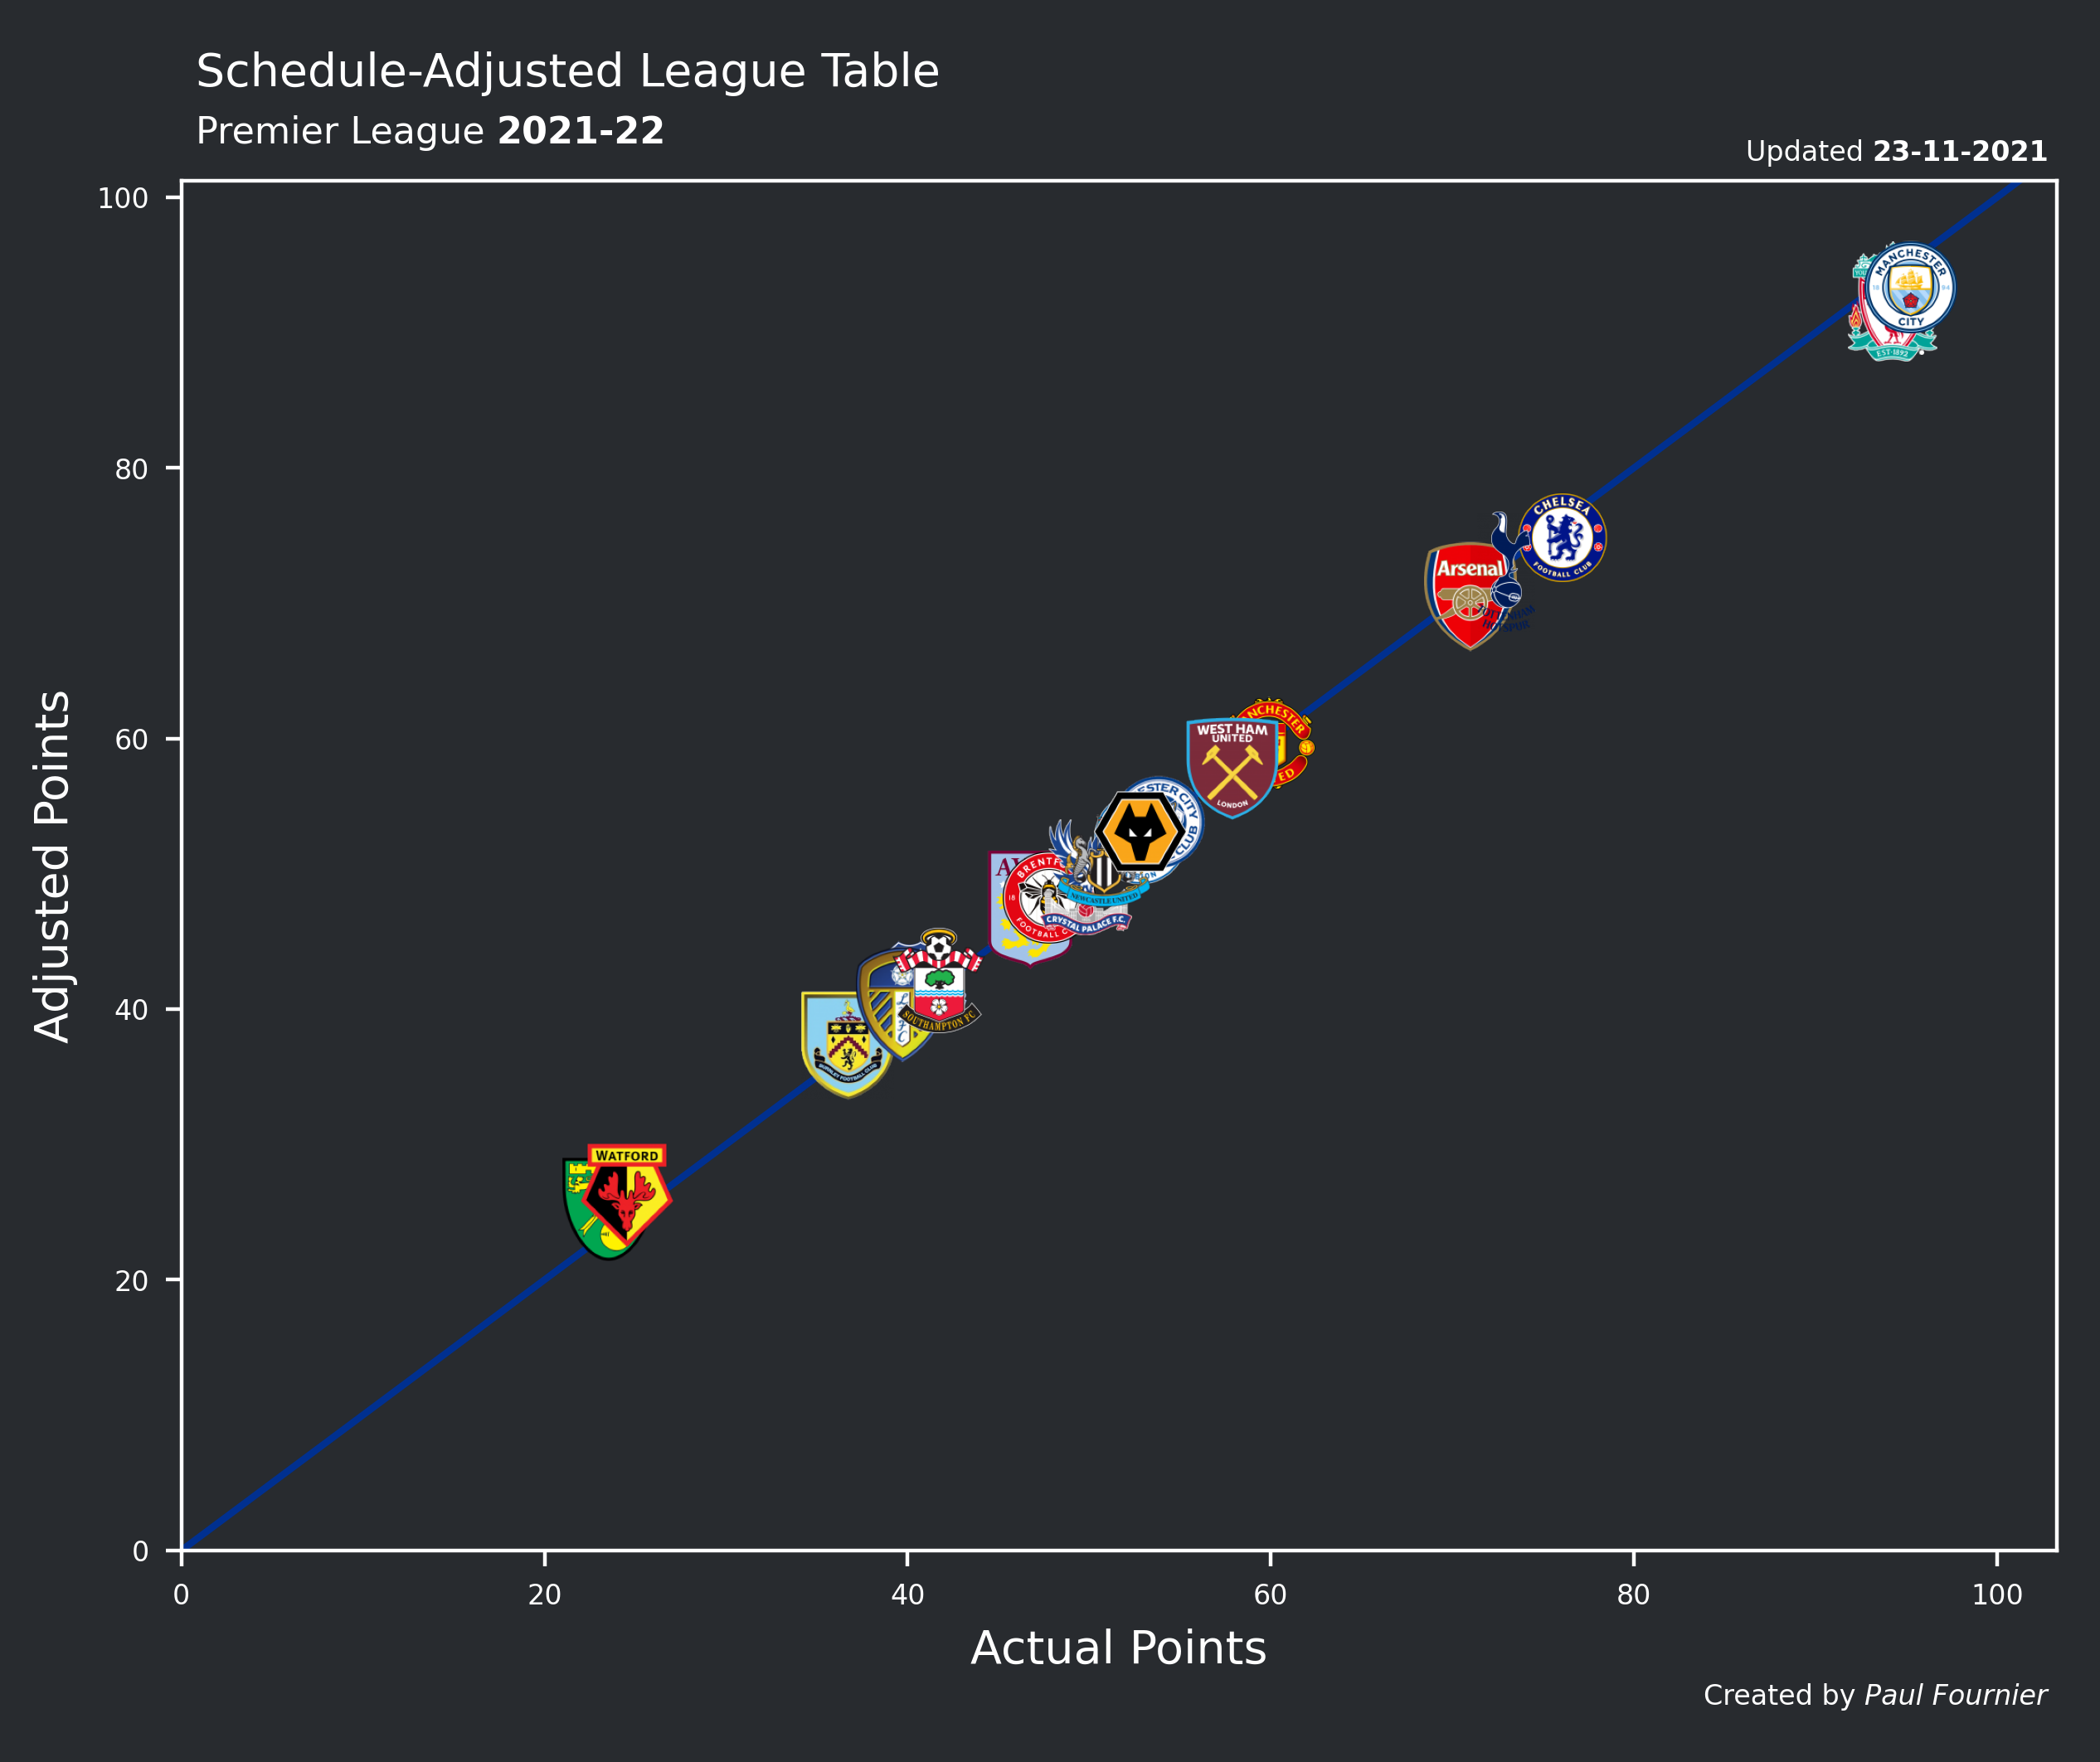

In [12]:
fig, ax = plt.subplots()
fig.set_facecolor(background)
ax.patch.set_alpha(0)

max_adj = salt.league_table["adj_points"].max() * 1.1
max_pts = salt.league_table["points"].max() * 1.1
ax.set(xlim=(0, max_pts+1), ylim=(0, max_adj+1))

ax.set_xlabel('Actual Points')
ax.set_ylabel('Adjusted Points')
ax.xaxis.label.set_color(text_color)
ax.yaxis.label.set_color(text_color)

ref_line = [0.0, max(max_adj, max_pts)+1]
ax.plot(ref_line, ref_line, color='#003090')

for idx, row in salt.league_table.iterrows():
    offset_image(row["points"], row["adj_points"], row["name"], ax)

fig_text(
    x=0.1, y=1.05,
    s="Schedule-Adjusted League Table",
    fontsize=10, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.1, y=1.01,
    s="Premier League <2021-22>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=8, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.83, y=.995,
    s="Updated <23-11-2021>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=6, fontfamily=title_font, color=text_color, alpha=1)

fig_text(
    x=0.81, y=0.025,
    s="Created by <Paul Fournier>",
    highlight_textprops=[{"fontstyle": "italic"}],
    fontsize=6, fontfamily=watermark_font,
    color=text_color)

plt.tight_layout()
plt.show()